In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tqdm import tqdm_notebook

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test', 'train', 'train.csv', 'sample_submission.csv']


In [2]:
#read in all our files
train_df = pd.read_csv('../input/train.csv')
train_images = '../input/train/*'
test_images = '../input/test/*'

In [3]:
train_df.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


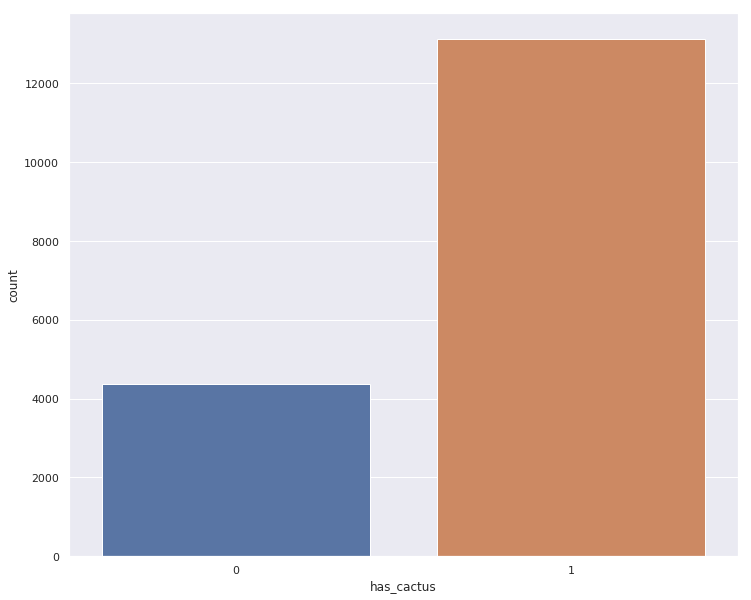

In [4]:
sns.set(style = 'darkgrid')
plt.figure(figsize = (12,10))
sns.countplot(train_df['has_cactus'])

In [5]:
#let's visualize some cactus images
IMAGES = os.path.join(train_images, "*")
all_images = glob.glob(IMAGES)

([], <a list of 0 Text yticklabel objects>)

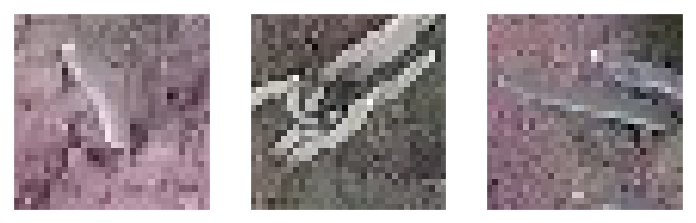

In [6]:
#visualize some images

plt.figure(figsize = (12,10))
plt.subplot(1, 3, 1)
plt.imshow(plt.imread(all_images[0]))
plt.xticks([])
plt.yticks([])

plt.subplot(1, 3, 2)
plt.imshow(plt.imread(all_images[10]))
plt.xticks([])
plt.yticks([])

plt.subplot(1, 3, 3)
plt.imshow(plt.imread(all_images[20]))
plt.xticks([])
plt.yticks([])

In [7]:
train_path = '../input/train/train/'
test_path = '../input/test/test/'

In [8]:
#let's get our image data and image labels toegether
#read in all the images
images_id = train_df['id'].values
X = [] #this list will contain all our images
for id_ in images_id:
    img = cv2.imread(train_path + id_)
    X.append(img)

In [9]:
#now let's get our labels
label_list = [] #will contain all our labels
for img_id in images_id:
    label_list.append(train_df[train_df['id'] == img_id]['has_cactus'].values[0])

In [10]:
#now we can convert our images list and the labels list into numpy array
X = np.array(X)
y = np.array(label_list)

In [11]:
print(f"THE SIZE OF OUR TRAINING DATA : {X.shape}")
print(f"THE SIZE OF OUR TRAINING LABELS : {y.shape}")

THE SIZE OF OUR TRAINING DATA : (17500, 32, 32, 3)
THE SIZE OF OUR TRAINING LABELS : (17500,)


In [12]:
#let's do some preprocessing such as normalizing our data
X = X.astype('float32') / 255

In [13]:
#loading in and preprocessing the test data
X_test = []
test_images = []
for img_id in tqdm_notebook(os.listdir(test_path)):
    X_test.append(cv2.imread(test_path + img_id))     
    test_images.append(img_id)
X_test = np.array(X_test)
X_test = X_test.astype('float32') / 255

## BUILD CNN

In [14]:
#import the required libraries
import keras
from keras.layers import Conv2D
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras.layers import Flatten
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import MaxPooling2D
from keras.models import Sequential
from keras import optimizers
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K

Using TensorFlow backend.


In [15]:
class CNN:
    def build(height, width, classes, channels):
        model = Sequential()
        inputShape = (height, width, channels)
        chanDim = -1
        
        if K.image_data_format() == 'channels_first':
            inputShape = (channels, height, width)
            chanDim = 1
        model.add(Conv2D(32, (3,3), padding = 'same', input_shape = inputShape))
        model.add(BatchNormalization(axis = chanDim))
        model.add(Activation('relu'))
        model.add(Conv2D(32, (3,3), padding = 'same'))
        model.add(BatchNormalization(axis = chanDim))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(2,2))
        model.add(Dropout(0.25))
        
        model.add(Conv2D(128, (3,3), padding = 'same', input_shape = inputShape))
        model.add(BatchNormalization(axis = chanDim))
        model.add(Activation('relu'))
        model.add(Conv2D(128, (3,3), padding = 'same'))
        model.add(BatchNormalization(axis = chanDim))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(2,2))
        model.add(Dropout(0.25))
        
        model.add(Conv2D(256, (3,3), padding = 'same', input_shape = inputShape))
        model.add(BatchNormalization(axis = chanDim))
        model.add(Activation('relu'))
        model.add(Conv2D(256, (3,3), padding = 'same'))
        model.add(BatchNormalization(axis = chanDim))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(2,2))
        model.add(Dropout(0.25))
        
        model.add(Flatten())
        
        model.add(Dense(128, activation = 'relu'))
        model.add(BatchNormalization(axis = chanDim))
        model.add(Dropout(0.5))
        
        model.add(Dense(32, activation = 'relu'))
        model.add(BatchNormalization(axis = chanDim))
        model.add(Dropout(0.5))
        
        model.add(Dense(classes, activation = 'sigmoid'))
        
        return model

## ENSEMBLE NEURAL NETWORK

In [16]:
input_dim = X.shape[1:]
activation = 'relu'
classes = 1
height = 32
width = 32
channels = 3

history = dict() #dictionery to store the history of individual models for later visualization
prediction_scores = dict() #dictionery to store the predicted scores of individual models on the test dataset

#here we will be training the same model for a total of 10 times and will be considering the mean of the output values for predictions
for i in np.arange(0, 5):
    optim = optimizers.Adam(lr = 0.001)
    ensemble_model = CNN.build(height = height, width = width, classes = classes, channels = channels)
    ensemble_model.compile(loss = 'binary_crossentropy', optimizer = optim, metrics = ['accuracy'])
    print('TRAINING MODEL NO : {}'.format(i))
    H = ensemble_model.fit(X, y,
                           batch_size = 32,
                           epochs = 200,
                           verbose = 1)
    history[i] = H
    
    ensemble_model.save('MODEL_{}.model'.format(i))
    
    predictions = ensemble_model.predict(X_test, verbose = 1, batch_size = 32)
    prediction_scores[i] = predictions

TRAINING MODEL NO : 0
Epoch 1/200
17500/17500 [==============================] - 12s 711us/step - loss: 0.2101 - acc: 0.9271
Epoch 2/200
17500/17500 [==============================] - 8s 461us/step - loss: 0.0847 - acc: 0.9743
Epoch 3/200
17500/17500 [==============================] - 8s 467us/step - loss: 0.0669 - acc: 0.9787
Epoch 4/200
17500/17500 [==============================] - 8s 460us/step - loss: 0.0560 - acc: 0.9831
Epoch 5/200
17500/17500 [==============================] - 8s 463us/step - loss: 0.0398 - acc: 0.9883
Epoch 6/200
17500/17500 [==============================] - 8s 461us/step - loss: 0.0435 - acc: 0.9875
Epoch 7/200
17500/17500 [==============================] - 8s 460us/step - loss: 0.0310 - acc: 0.9905
Epoch 8/200
17500/17500 [==============================] - 8s 461us/step - loss: 0.0294 - acc: 0.9914
Epoch 9/200
17500/17500 [==============================] - 8s 457us/step - loss: 0.0223 - acc: 0.9937
Epoch 10/200
17500/17500 [==============================] -

## VGG16

In [17]:
from keras.applications.vgg16 import VGG16

In [18]:
vgg16 = VGG16(weights = 'imagenet', input_shape = (32, 32, 3), include_top = False)
vgg16.summary()

58892288/58889256 [==============================] - 1s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool

In [19]:
for layer in vgg16.layers:
    layer.trainable = False

In [20]:
vgg_model = Sequential()
vgg_model.add(vgg16)
vgg_model.add(Flatten())
vgg_model.add(Dense(256, activation = 'relu'))
vgg_model.add(BatchNormalization())
vgg_model.add(Dropout(0.5))
vgg_model.add(Dense(128, activation = 'relu'))
vgg_model.add(BatchNormalization())
vgg_model.add(Dropout(0.5))
vgg_model.add(Dense(1, activation = 'sigmoid'))

vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_6 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_41 (Batc (None, 256)               1024      
_________________________________________________________________
dropout_26 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 128)               32896     
_________________________________________________________________
batch_normalization_42 (Batc (None, 128)               512       
__________

In [21]:
#compile the model
vgg_model.compile(loss = 'binary_crossentropy', optimizer = optim, metrics = ['accuracy'])

In [22]:
#fit the model on our data
vgg_history = vgg_model.fit(X, y,
                            batch_size = 64,
                            epochs = 500,
                            verbose = 1) 

Epoch 1/500
17500/17500 [==============================] - 6s 320us/step - loss: 0.1719 - acc: 0.9358
Epoch 2/500
17500/17500 [==============================] - 4s 203us/step - loss: 0.1074 - acc: 0.9611
Epoch 3/500
17500/17500 [==============================] - 4s 203us/step - loss: 0.0990 - acc: 0.9636
Epoch 4/500
17500/17500 [==============================] - 4s 203us/step - loss: 0.0892 - acc: 0.9658
Epoch 5/500
17500/17500 [==============================] - 4s 203us/step - loss: 0.0869 - acc: 0.9683
Epoch 6/500
17500/17500 [==============================] - 4s 203us/step - loss: 0.0828 - acc: 0.9701
Epoch 7/500
17500/17500 [==============================] - 4s 203us/step - loss: 0.0766 - acc: 0.9723
Epoch 8/500
17500/17500 [==============================] - 4s 201us/step - loss: 0.0802 - acc: 0.9686
Epoch 9/500
17500/17500 [==============================] - 4s 202us/step - loss: 0.0755 - acc: 0.9718
Epoch 10/500
17500/17500 [==============================] - 4s 202us/step - loss: 

In [23]:
#making predictions on test dat
predictions_vgg = vgg_model.predict(X_test)

In [24]:
predictions_vgg.shape

(4000, 1)

## RESNET50

In [25]:
from keras.applications.resnet50 import ResNet50

In [26]:
resnet = ResNet50(weights = 'imagenet', input_shape = (32, 32, 3), include_top = False)
resnet.summary()

/opt/conda/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 1s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 16, 16, 64)   256         conv1[0][0]                      
____________________________________________

In [27]:
for layer in resnet.layers:
    layer.trainable = False

In [28]:
resnet_model = Sequential()
resnet_model.add(resnet)
resnet_model.add(Flatten())
resnet_model.add(Dense(256, activation = 'relu'))
resnet_model.add(BatchNormalization())
resnet_model.add(Dropout(0.5))
resnet_model.add(Dense(128, activation = 'relu'))
resnet_model.add(BatchNormalization())
resnet_model.add(Dropout(0.5))
resnet_model.add(Dense(1, activation = 'sigmoid'))

resnet_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 1, 1, 2048)        23587712  
_________________________________________________________________
flatten_7 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 256)               524544    
_________________________________________________________________
batch_normalization_43 (Batc (None, 256)               1024      
_________________________________________________________________
dropout_28 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 128)               32896     
_________________________________________________________________
batch_normalization_44 (Batc (None, 128)               512       
__________

In [29]:
#compile the model
resnet_model.compile(loss = 'binary_crossentropy', optimizer = optim, metrics = ['accuracy'])

In [30]:
#fit the model on our data
resnet_history = resnet_model.fit(X, y,
                                  batch_size = 64, 
                                  epochs = 500,
                                  verbose = 1) 

Epoch 1/500
17500/17500 [==============================] - 10s 574us/step - loss: 0.1821 - acc: 0.9312
Epoch 2/500
17500/17500 [==============================] - 5s 298us/step - loss: 0.1203 - acc: 0.9552
Epoch 3/500
17500/17500 [==============================] - 5s 295us/step - loss: 0.0996 - acc: 0.9625
Epoch 4/500
17500/17500 [==============================] - 5s 295us/step - loss: 0.0987 - acc: 0.9617
Epoch 5/500
17500/17500 [==============================] - 5s 295us/step - loss: 0.0914 - acc: 0.9627
Epoch 6/500
17500/17500 [==============================] - 5s 299us/step - loss: 0.0881 - acc: 0.9666
Epoch 7/500
17500/17500 [==============================] - 5s 295us/step - loss: 0.0886 - acc: 0.9674
Epoch 8/500
17500/17500 [==============================] - 5s 294us/step - loss: 0.0824 - acc: 0.9683
Epoch 9/500
17500/17500 [==============================] - 5s 294us/step - loss: 0.0769 - acc: 0.9713
Epoch 10/500
17500/17500 [==============================] - 5s 293us/step - loss:

In [31]:
resnet_predictions = resnet_model.predict(X_test)

## MAKING SUBMISSIONS

1. Ensemble Model

In [32]:
#making predictions
prediction = np.hstack([p.reshape(-1,1) for p in prediction_scores.values()]) #taking the scores of all the trained models
predictions_ensemble = np.mean(prediction, axis = 1)
print(predictions_ensemble.shape)

(4000,)


In [33]:
df_ensemble = pd.DataFrame(predictions_ensemble, columns = ['has_cactus'])
df_ensemble['has_cactus'] = df_ensemble['has_cactus'].apply(lambda x: 1 if x > 0.75 else 0)

In [34]:
df_ensemble['id'] = ''
cols = df_ensemble.columns.tolist()
cols = cols[-1:] + cols[:-1]
df_ensemble = df_ensemble[cols]

for i, img in enumerate(test_images):
    df_ensemble.set_value(i,'id',img)

#making submission
df_ensemble.to_csv('ensemble_submission.csv',index = False)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  import sys


2. VGG16

In [35]:
df_vgg = pd.DataFrame(predictions_vgg, columns = ['has_cactus'])
df_vgg['has_cactus'] = df_vgg['has_cactus'].apply(lambda x: 1 if x > 0.75 else 0)

In [36]:
df_vgg['id'] = ''
cols = df_vgg.columns.tolist()
cols = cols[-1:] + cols[:-1]
df_vgg = df_vgg[cols]

for i, img in enumerate(test_images):
    df_vgg.set_value(i,'id',img)

#making submission
df_vgg.to_csv('vgg_submission.csv',index = False)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  import sys


In [37]:
df_vgg.head()

,id,has_cactus
0,c662bde123f0f83b3caae0ffda237a93.jpg,1
1,9553eed7793d4cf88b5226d446d93dae.jpg,0
2,19f059a7ce41b25be1548bc4049b45ec.jpg,1
3,fb4f464486f4894330273346ce939252.jpg,1
4,b52558a522db6ec2501ae188b6d6e526.jpg,1


3. Resnet50

In [38]:
df_resnet = pd.DataFrame(resnet_predictions, columns = ['has_cactus'])
df_resnet['has_cactus'] = df_resnet['has_cactus'].apply(lambda x: 1 if x > 0.75 else 0)

In [39]:
df_resnet['id'] = ''
cols = df_resnet.columns.tolist()
cols = cols[-1:] + cols[:-1]
df_resnet = df_resnet[cols]

for i, img in enumerate(test_images):
    df_resnet.set_value(i,'id',img)

#making submission
df_resnet.to_csv('resnet_submission.csv',index = False)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  import sys


4. Ensemble and VGG16

In [40]:
df_vgg1 = pd.DataFrame(predictions_vgg, columns = ['has_cactus'])
df_ensemble1 = pd.DataFrame(predictions_ensemble, columns = ['has_cactus'])

df_t = 0.5 * df_vgg1['has_cactus'] + 0.5 * df_ensemble1['has_cactus']
df_t = pd.DataFrame(df_t, columns = ['has_cactus'])
df_t['has_cactus'] = df_t['has_cactus'].apply(lambda x: 1 if x > 0.75 else 0)

df_t['id'] = ''
cols = df_t.columns.tolist()
cols = cols[-1:] + cols[:-1]
df_t = df_t[cols]

for i, img in enumerate(test_images):
    df_t.set_value(i,'id',img)

#making submission
df_t.to_csv('vgg_ensemble_submission.csv',index = False)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


5. Ensemble, VGG16 and ResNet50

In [41]:
df_vgg2 = pd.DataFrame(predictions_vgg, columns = ['has_cactus'])
df_ensemble2 = pd.DataFrame(predictions_ensemble, columns = ['has_cactus'])
df_resnet2 = pd.DataFrame(resnet_predictions, columns = ['has_cactus'])

df_t2 = 0.45 * df_vgg2['has_cactus'] + 0.45 * df_ensemble2['has_cactus'] + 0.10 * df_resnet2['has_cactus']
df_t2 = pd.DataFrame(df_t2, columns = ['has_cactus'])
df_t2['has_cactus'] = df_t2['has_cactus'].apply(lambda x: 1 if x > 0.75 else 0)

df_t2['id'] = ''
cols = df_t2.columns.tolist()
cols = cols[-1:] + cols[:-1]
df_t2 = df_t2[cols]

for i, img in enumerate(test_images):
    df_t2.set_value(i,'id',img)

#making submission
df_t2.to_csv('vgg_ensemble_resnet_submission.csv',index = False)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  from ipykernel import kernelapp as app
